<a href="https://colab.research.google.com/github/andr3w1699/Intelligent_System_for_Pattern_Recognition/blob/main/SecondAssignement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second assignement ISPR: ANDREA LEPORI

Selected assignement:

Assignment 3

Implement from scratch an RBM and apply it to DSET2. The RBM should be implemented fully by you (both training and inference steps) but you are free to use library functions for the rest (e.g. image loading and management, etc.). Implement a generalization of the Contrastive Divergence (CD) learning algorithm that defines the number of steps K of the Gibbs sampling Markov chain runned before collecting the samples to estimate the model expectation. For instance the standard CD learning would be obtained with K=1. Test your models by training two versions of them, one with a small K and one with a medium K (I suggest you do not go over 10 steps), and discuss the differences in performance/behaviour (if any).

Outline of the assigment:

1.     Train an RBM with a number of hidden neurons selected by you (single layer) on the MNIST data (use the training set split provided by the website) using CD(K) with two choices of K.

2.     Use the trained RBMs to encode a selection of test images (e.g. using one per digit type) using the corresponding activation of the hidden neurons.

3.    Train a simple classifier (e.g. any simple classifier in scikit) to recognize the MNIST digits using as inputs their encoding obtained at step 2. Use the standard training/test split. Show a performance metric of your choice in the presentation/handout and use it to confront the two versions of the RBM (obtained with different K).

Dataset:
DSET2 (Image processing: MNIST): (https://www.kaggle.com/datasets/hojjatk/mnist-dataset) or (https://huggingface.co/datasets/ylecun/mnist/) or (http://yann.lecun.com/exdb/mnist/)


In [1]:
!pip install numpy torch scikit-learn matplotlib torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# import libraries
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [3]:
# Load MNIST Dataset

# This defines how each image in the dataset should be preprocessed before being used.
# transforms.ToTensor() converts each image (which is in PIL Image format) into a PyTorch tensor with values scaled between 0 and 1.
# transforms.Compose([...]) lets you chain multiple transforms together, though here we’re just using one (ToTensor()).
transform = transforms.Compose([transforms.ToTensor()])

# download and store the training and test portion of the MNIST dataset
# The dataset will be stored in a folder called data in your project directory.
# train=True --> training, train=False --> test set.
# download=True: Downloads the dataset automatically if it's not already there.
# transform=transform: Applies the ToTensor() transform to each image when it's loaded.
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Wraps the dataset in a DataLoader, which is an iterator that loads the data in batches.
# batch_size=64: Each time you ask for a batch, it gives you 64 images (and their labels).
# shuffle=True: Randomly shuffles the dataset each epoch, which helps make training more effective (less bias from order).
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# same idea, but for the test set, fetches larger batches for faster evaluation (you don't need to update weights during testing).
# shuffle=False: We don’t shuffle the test set — it’s okay to evaluate in order.
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 158kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.85MB/s]


Batch shape: torch.Size([64, 1, 28, 28])
Label shape: torch.Size([64])


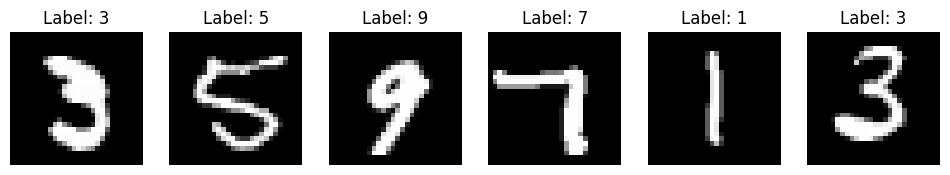

In [4]:
# Get one batch from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the shape
print(f"Batch shape: {images.shape}")      # (batch_size, 1, 28, 28)
print(f"Label shape: {labels.shape}")      # (batch_size,)

# Show the first 6 images with labels
fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    img = images[i].squeeze()  # Remove channel dimension (1,28,28) -> (28,28)
    label = labels[i].item()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()

# Understanding image representation:

`images.shape` → `(64, 1, 28, 28)`

*   64 images in this batch
*   Each image has 1 channel (grayscale)
*   Each image is 28x28 pixels
*   Pixel values are in the range [0, 1] (because of ToTensor())
*   Each image is stored as a PyTorch tensor




In [5]:
# to see the raw tensor (pixel values):
print(images[0])               # Tensor of shape (1, 28, 28)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [6]:
print(images[0][0])            # First channel (since it's grayscale, just one)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [7]:
print(images[0][0][:5, :5])    # Top-left 5x5 corner pixel values

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


# RBM Implementation (from scratch)

In [8]:
class RBM:
  def __init__(self, n_visible, n_hidden, k=1, learning_rate=0.0001):
    # number of input neurons (in MNIST pixels of an image --> 28x28 = 784)
    self.n_visible = n_visible
    # number of hidden units (it's an hyperparameter)
    self.n_hidden = n_hidden
    # number of Gibbs sampling steps for Contrastive Divergence (CD-k).
    self.k = k
    # step size for updating the weights and biases.
    self.learning_rate = learning_rate

    # W is the weight matrix connecting visible to hidden units.
    # Shape = n_hidden x n_visible. Initialized to Random small values
    self.W = torch.randn(n_hidden, n_visible) * 0.01  # weight matrix
    self.h_bias = torch.zeros(n_hidden)               # hidden bias
    self.v_bias = torch.zeros(n_visible)              # visible bias


  # Sample hidden units given visible units
  # params: v is a batch of visible units
  def sample_h(self, v):
        # computes wx that is the weighthed sum + bias for hidden units
        wx = torch.matmul(v, self.W.t()) + self.h_bias
        # computes probability of activation
        prob = torch.sigmoid(wx)
        # returns probabilities and sampled binary activations (0 or 1)
        return prob, torch.bernoulli(prob)

  # Sample visible units given hidden units
  # Reverse of sample_h. Given hidden units, reconstruct visible units
  # Returns probabilities + samples for visible layer
  def sample_v(self, h):
        wx = torch.matmul(h, self.W) + self.v_bias
        prob = torch.sigmoid(wx)
        return prob, torch.bernoulli(prob)

  def contrastive_divergence(self, v0):
        # start with input v0 (original data/training example)
        v = v0
        # run k steps of Gibbs sampling
        # sample h from v, then v from h, repeatedly
        # this gives the model's approximation of the input data (its "fantasy" or "dream")
        for _ in range(self.k):
            ph, h = self.sample_h(v)
            pv, v = self.sample_v(h)

        # Positive and negative phases
        # positive phase: compute hidden activations from original input
        ph0, h0 = self.sample_h(v0)
        # negative phase: compute hidden activations from model-generated (sampled) input after k steps.
        phk, hk = self.sample_h(v)

        # Update weights and biases using the difference between positive and negative phases
        # intuition: update weights and biases using the difference between positive and negative phases
        self.W += self.learning_rate * (torch.matmul(h0.t(), v0) - torch.matmul(hk.t(), v))
        self.v_bias += self.learning_rate * torch.sum(v0 - v, dim=0)
        self.h_bias += self.learning_rate * torch.sum(h0 - hk, dim=0)


  def train(self, train_loader, n_epochs=5):
    for epoch in range(n_epochs):
        loss = 0
        for images, _ in train_loader:
            images = images.view(-1, self.n_visible)
            images = (images > 0.5).float()
            self.contrastive_divergence(images)
            loss += torch.mean((images - self.reconstruct(images)) ** 2).item()
        print(f"Epoch {epoch + 1}, Loss: {loss / len(train_loader)}")

  def reconstruct(self, v):
      prob_h, h = self.sample_h(v)
      prob_v, v_sample = self.sample_v(prob_h)
      return prob_v

  def encode(self, v):
      prob_h, _ = self.sample_h(v)
      return prob_h

  def show_learnt_features(self, num_features=100):
    """
    Visualize learned features (rows of weight matrix) as 28x28 images.
    """

    # Clamp number of features to number of hidden units
    num_features = min(num_features, self.n_hidden)
    grid_size = int(np.ceil(np.sqrt(num_features)))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    for idx in range(num_features):
        row = idx // grid_size
        col = idx % grid_size
        ax = axes[row, col]
        weight_img = self.W[idx].detach().numpy().reshape(28, 28)
        ax.imshow(weight_img, cmap='gray')
        ax.axis('off')

    for i in range(num_features, grid_size * grid_size):
        axes[i // grid_size, i % grid_size].axis('off')

    plt.suptitle("Learned Features", fontsize='x-large')
    plt.tight_layout()
    plt.show()

Epoch 1, Loss: 0.07127079611092108
Epoch 2, Loss: 0.05046227600957666
Epoch 3, Loss: 0.042659212308906035
Epoch 4, Loss: 0.037701847381206716
Epoch 5, Loss: 0.03435631917674404


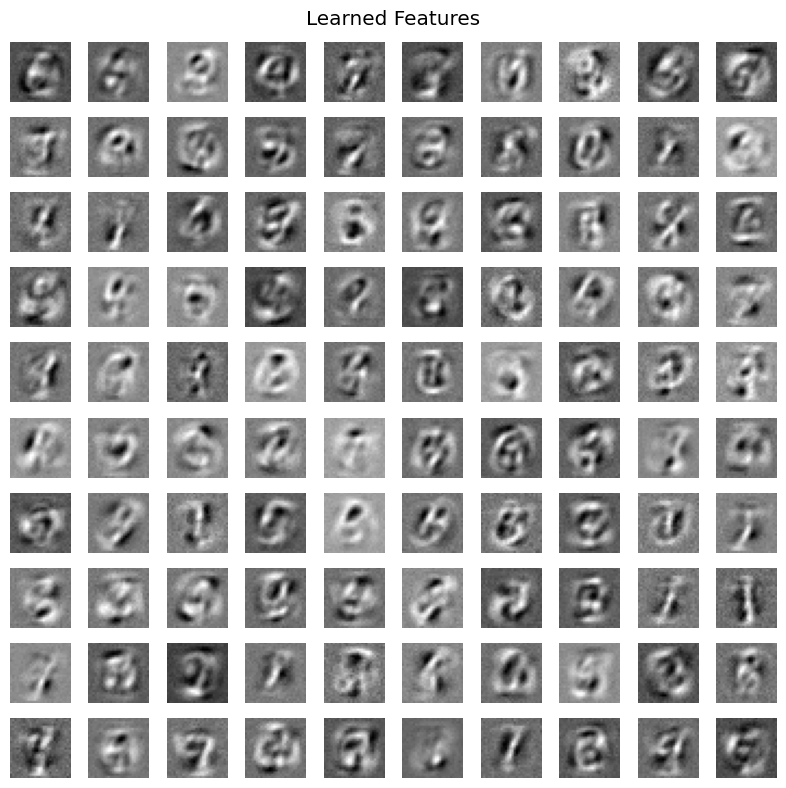

Epoch 1, Loss: 0.0709629334064562
Epoch 2, Loss: 0.04995315786061892
Epoch 3, Loss: 0.04195535263177683
Epoch 4, Loss: 0.037014818152607376
Epoch 5, Loss: 0.03369292654375087


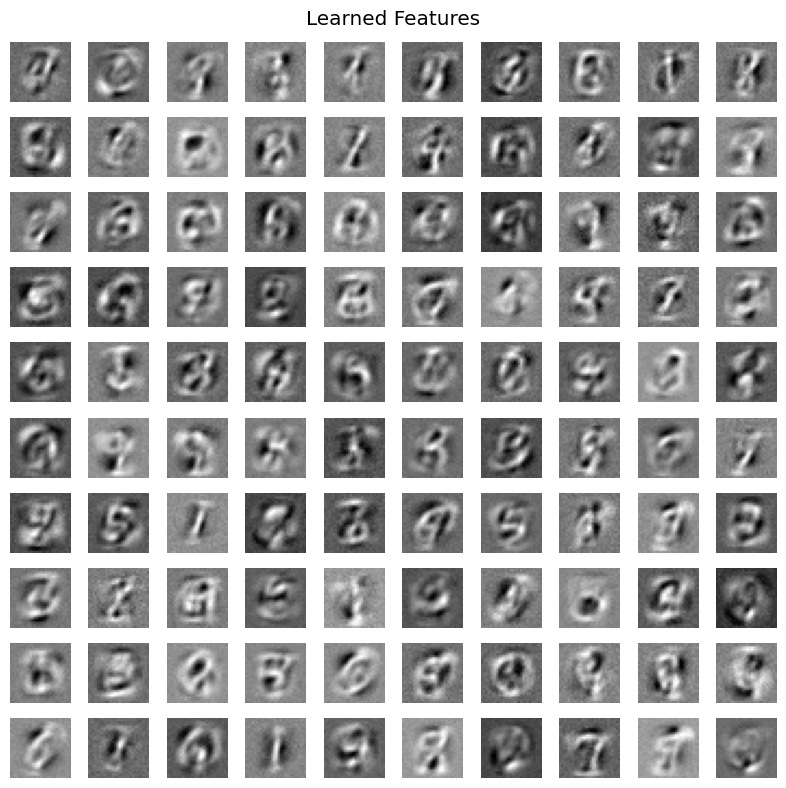

In [9]:
n_visible = 28 * 28
n_hidden = 512

# RBM with K=1
rbm_k1 = RBM(n_visible=n_visible, n_hidden=n_hidden, k=1)
rbm_k1.train(train_loader, n_epochs=5)
rbm_k1.show_learnt_features()

# RBM with K=5
rbm_k5 = RBM(n_visible=n_visible, n_hidden=n_hidden, k=10)
rbm_k5.train(train_loader, n_epochs=5)
rbm_k5.show_learnt_features()

In [10]:
def get_encoded_features(rbm, data_loader):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.view(-1, 28*28)
            images = (images > 0.5).float()
            encoded = rbm.encode(images)
            features.append(encoded.numpy())
            labels.append(targets.numpy())
    return np.vstack(features), np.hstack(labels)

X_train_k1, y_train_k1 = get_encoded_features(rbm_k1, train_loader)
X_test_k1, y_test_k1 = get_encoded_features(rbm_k1, test_loader)

X_train_k5, y_train_k5 = get_encoded_features(rbm_k5, train_loader)
X_test_k5, y_test_k5 = get_encoded_features(rbm_k5, test_loader)

In [11]:
# --- Classifier for RBM with k=1 ---
clf_k1 = LogisticRegression(max_iter=1000)
clf_k1.fit(X_train_k1, y_train_k1)

# Predictions
train_pred_k1 = clf_k1.predict(X_train_k1)
test_pred_k1 = clf_k1.predict(X_test_k1)

# Accuracy
train_acc_k1 = accuracy_score(y_train_k1, train_pred_k1)
test_acc_k1 = accuracy_score(y_test_k1, test_pred_k1)

# --- Classifier for RBM with k=5 ---
clf_k5 = LogisticRegression(max_iter=1000)
clf_k5.fit(X_train_k5, y_train_k5)

train_pred_k5 = clf_k5.predict(X_train_k5)
test_pred_k5 = clf_k5.predict(X_test_k5)

train_acc_k5 = accuracy_score(y_train_k5, train_pred_k5)
test_acc_k5 = accuracy_score(y_test_k5, test_pred_k5)

# Print results
print(f"RBM k=1 - Train Accuracy: {train_acc_k1 * 100:.2f}% | Test Accuracy: {test_acc_k1 * 100:.2f}%")
print(f"RBM k=5 - Train Accuracy: {train_acc_k5 * 100:.2f}% | Test Accuracy: {test_acc_k5 * 100:.2f}%")

RBM k=1 - Train Accuracy: 97.33% | Test Accuracy: 96.63%
RBM k=5 - Train Accuracy: 97.28% | Test Accuracy: 96.51%


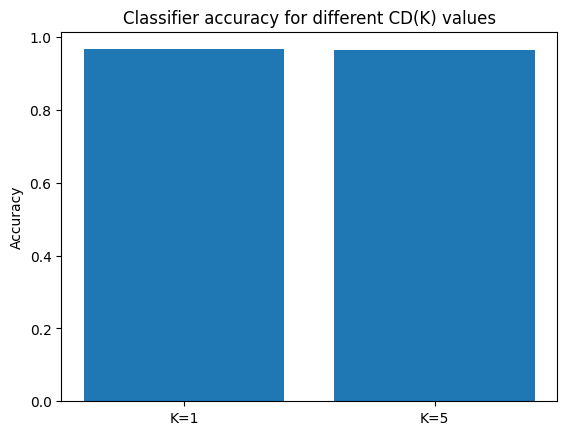

In [12]:
plt.bar(['K=1', 'K=5'], [test_acc_k1, test_acc_k5])
plt.ylabel("Accuracy")
plt.title("Classifier accuracy for different CD(K) values")
plt.show()

In [20]:
def visualize_rbm_with_hidden_activations(rbm, test_loader, n_digits=10):
    digit_samples = {}
    with torch.no_grad():
        for images, labels in test_loader:
            for img, lbl in zip(images, labels):
                lbl = lbl.item()
                if lbl not in digit_samples:
                    digit_samples[lbl] = img
                if len(digit_samples) == n_digits:
                    break
            if len(digit_samples) == n_digits:
                break

    fig, axs = plt.subplots(nrows=3, ncols=n_digits, figsize=(n_digits * 1.8, 5.5))
    fig.suptitle("Original (Top), Reconstructed (Middle), Hidden Activations (Bottom)", fontsize=14)

    for i in range(n_digits):
        img = digit_samples[i]
        img_flat = img.view(-1).unsqueeze(0)
        binary_img = (img_flat > 0.5).float()

        # Encode to get binary sample instead of probabilities
        _, encoded = rbm.sample_h(binary_img)
        hidden_activations = encoded.squeeze().numpy()  # values will be 0 or 1
        hidden_img = hidden_activations.reshape(16, 32)  # or (32, 16)
        reconstructed = rbm.reconstruct(binary_img).view(28, 28).numpy()
        hidden_activations = encoded.squeeze().numpy()

        # Original image
        axs[0, i].imshow(img.squeeze(), cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title(f"Digit {i}")

        # Reconstructed image
        axs[1, i].imshow(reconstructed, cmap='gray')
        axs[1, i].axis('off')

        # Hidden activations as heatmap (reshape for visual effect if possible)
        axs[2, i].imshow(hidden_img, cmap='gray')  # or 'binary' or 'hot'
        axs[2, i].axis('off')

    plt.tight_layout()
    plt.show()

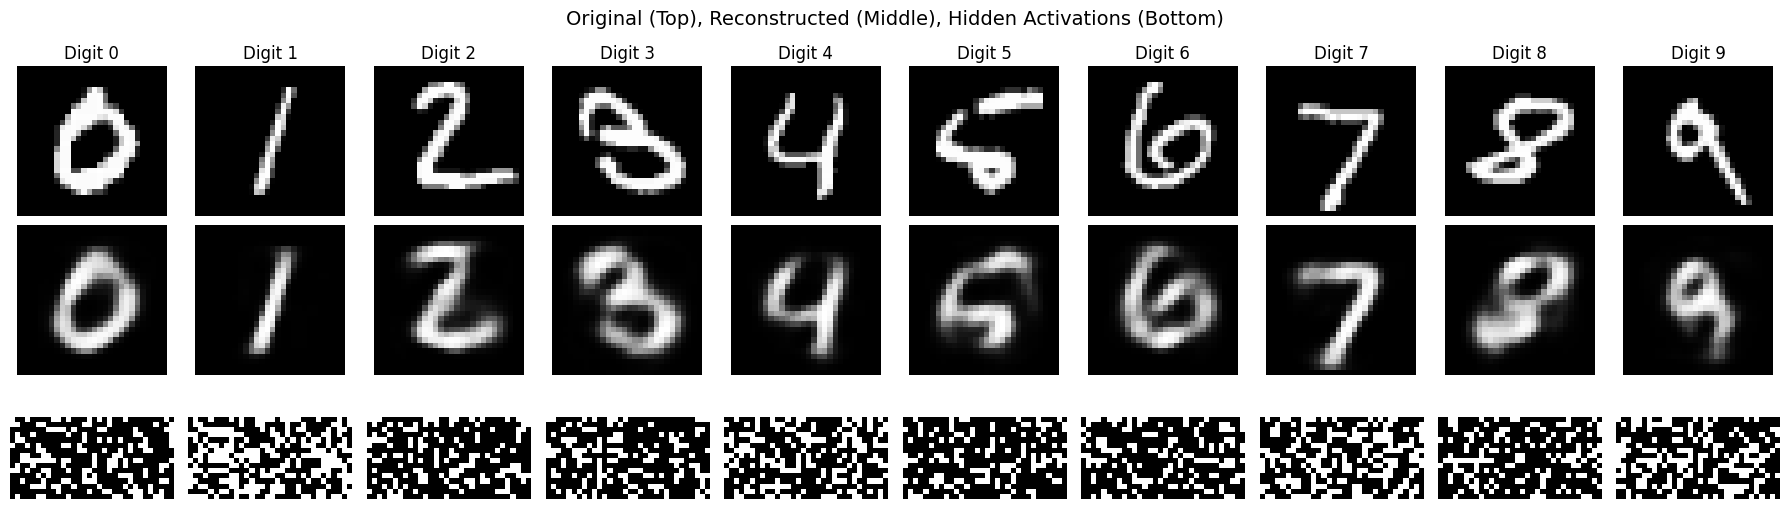

In [21]:
visualize_rbm_with_hidden_activations(rbm_k1, test_loader)

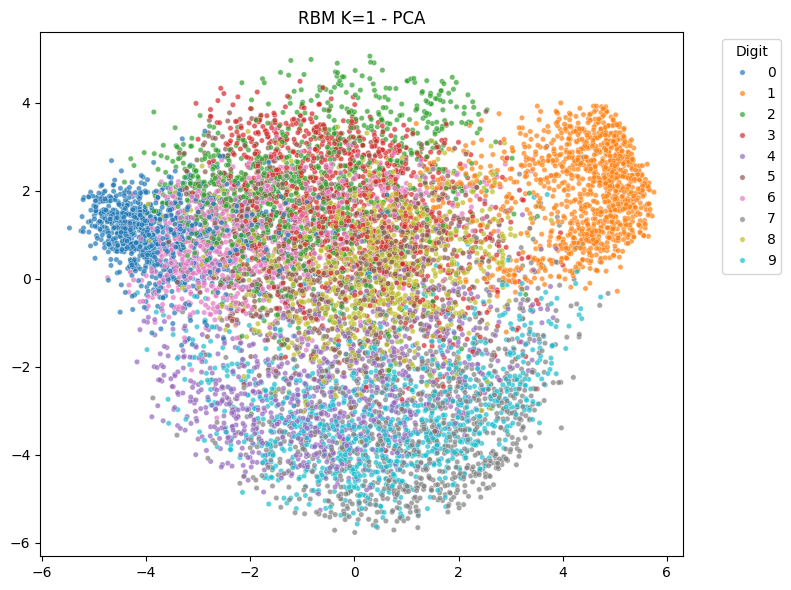

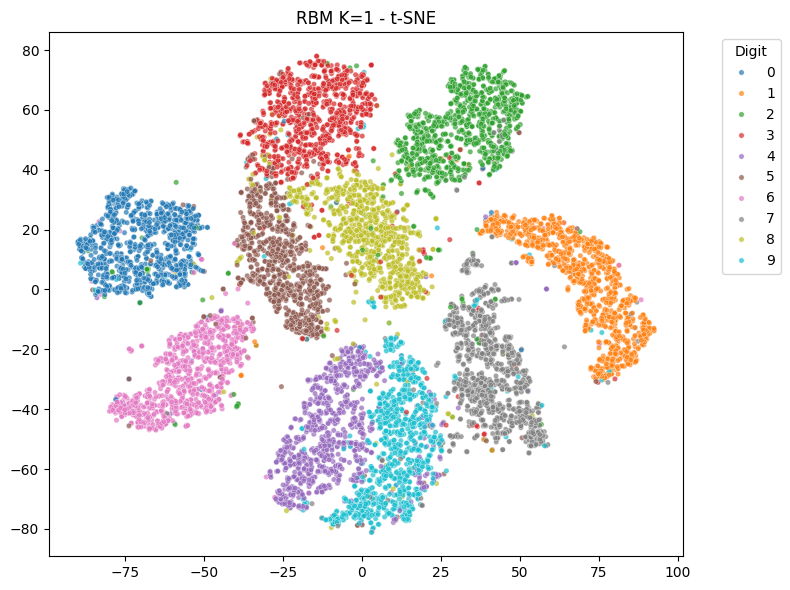

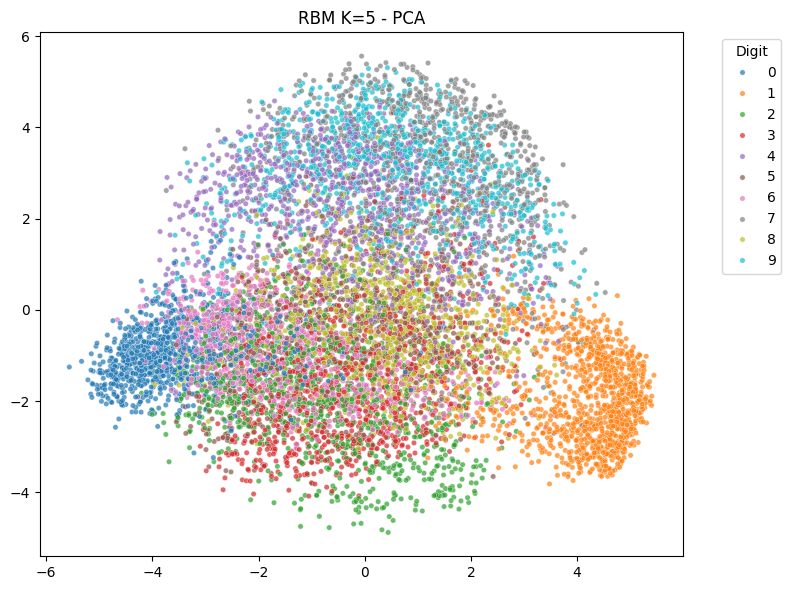

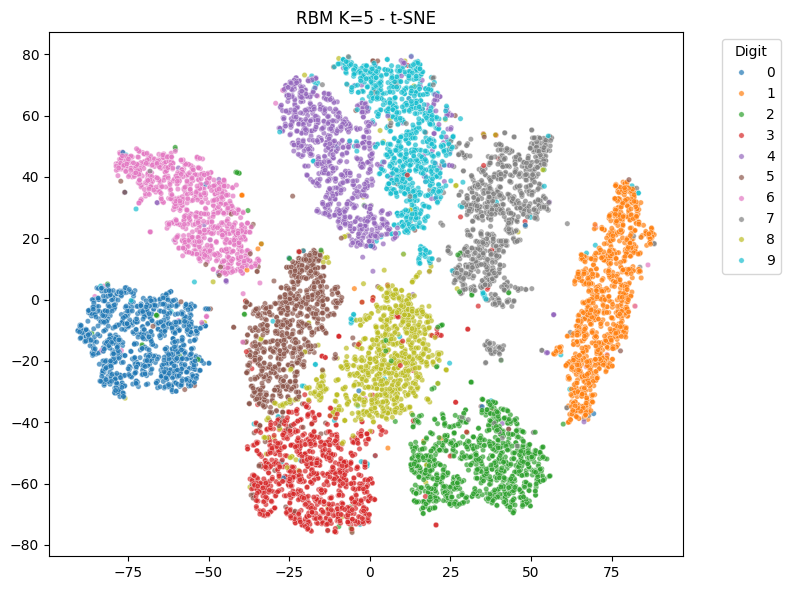

In [15]:
def plot_embedding(X, y, method='pca', title=''):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    X_embedded = reducer.fit_transform(X)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, palette="tab10", s=15, alpha=0.7)
    plt.title(title)
    plt.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


plot_embedding(X_test_k1, y_test_k1, method='pca', title='RBM K=1 - PCA')
plot_embedding(X_test_k1, y_test_k1, method='tsne', title='RBM K=1 - t-SNE')

plot_embedding(X_test_k5, y_test_k5, method='pca', title='RBM K=5 - PCA')
plot_embedding(X_test_k5, y_test_k5, method='tsne', title='RBM K=5 - t-SNE')

In [22]:
def visualize_denoising(rbm, test_loader, digit=2, steps=10, noise_level=0.4):
    # Step 1: Get one sample of the desired digit
    for image, label in test_loader:
        mask = (label == digit)
        if mask.any():
            original_img = image[mask][0].view(1, -1)
            break

    # Step 2: Binarize and add noise
    original_img = (original_img > 0.5).float()
    noisy_img = original_img.clone()
    noise = torch.bernoulli(torch.full_like(noisy_img, noise_level))
    noisy_img = (noisy_img + noise) % 2  # flip bits with probability = noise_level

    # Store reconstructions
    reconstructions = [noisy_img.view(28, 28).numpy()]
    v = noisy_img.clone()

    # Step 3: Perform multiple Gibbs steps
    for _ in range(steps):
        prob_h, h = rbm.sample_h(v)
        prob_v, v = rbm.sample_v(h)
        reconstructions.append(prob_v.view(28, 28).detach().numpy())

    # Step 4: Plot everything
    n_cols = steps + 2
    fig, ax = plt.subplots(1, n_cols, figsize=(2.5 * n_cols, 3))

    ax[0].imshow(original_img.view(28, 28).numpy(), cmap="gray")
    ax[0].set_title("Original")
    ax[0].axis('off')

    ax[1].imshow(reconstructions[0], cmap="gray")
    ax[1].set_title(f"Noisy (p={noise_level})")
    ax[1].axis('off')

    for i in range(1, steps + 1):
        ax[i + 1].imshow(reconstructions[i], cmap="gray")
        ax[i + 1].set_title(f"Step {i}")
        ax[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

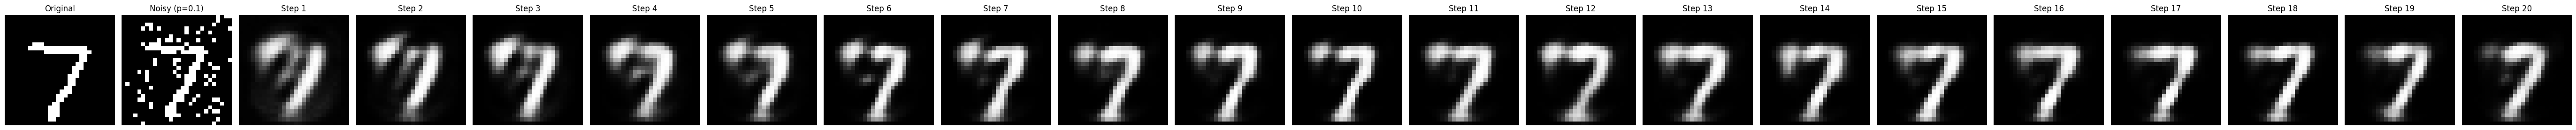

In [74]:
visualize_denoising(rbm_k5, test_loader, digit=7, steps=20, noise_level=0.1)
